In [3]:
import tensorflow as tf
import optuna
import shap
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend, constraints, initializers, regularizers
from sklearn.preprocessing import StandardScaler

In [ ]:
! pip install optuna

In [ ]:
!pip install shap

In [6]:
df = pd.read_csv('truncated_LOB_data_BTC_USD_COINBASE.csv')

In [4]:
def finder_of_fulfilment(df, column):
    time, indicator = [], []
    if 'bid' in column:
      repr_column = 'ask_prices_0'
    else:
      repr_column = 'bid_prices_0'
    for i in range(len(df)):
        num = df[column].iloc[i]
        arr = df[df[repr_column]>num][repr_column].index
        time.append(pd.to_datetime(df['timestamp'].iloc[arr[arr>i][0]]) - pd.to_datetime(df['timestamp'].iloc[i])
                    if len(arr[arr>i]) else
                    pd.to_datetime('2023-10-03 00:00:00') - pd.to_datetime(df['timestamp'].iloc[i]))
    return time

In [8]:
columns = ['bid_prices_0', 'ask_prices_0',	'bid_prices_1',	'ask_prices_1',	'bid_prices_2', 'ask_prices_2', 'bid_prices_3', 'ask_prices_3', 'bid_prices_4',	'ask_prices_4']
for column in columns:
  df['time_'+column] =  finder_of_fulfilment(df, column)

In [9]:
for column in columns:
  df['time_'+column] = round((df['time_'+column]).dt.total_seconds().astype(float),2)

In [10]:
def plot_KM_estimator(column):
  #df['time_'+column] = round((df['time_'+column]).dt.total_seconds().astype(float),2)
  times = np.sort(df['time_'+column].unique())
  S_of_t = []

  for time in times:
      num_executed = len(df[df['time_'+column]==time])
      num_survived = len(df[df['time_'+column]>time])
      prob = num_executed/(num_survived+num_executed)
      S_of_t.append(1-prob)


  S_hat = np.cumprod(S_of_t)
  return S_hat, times

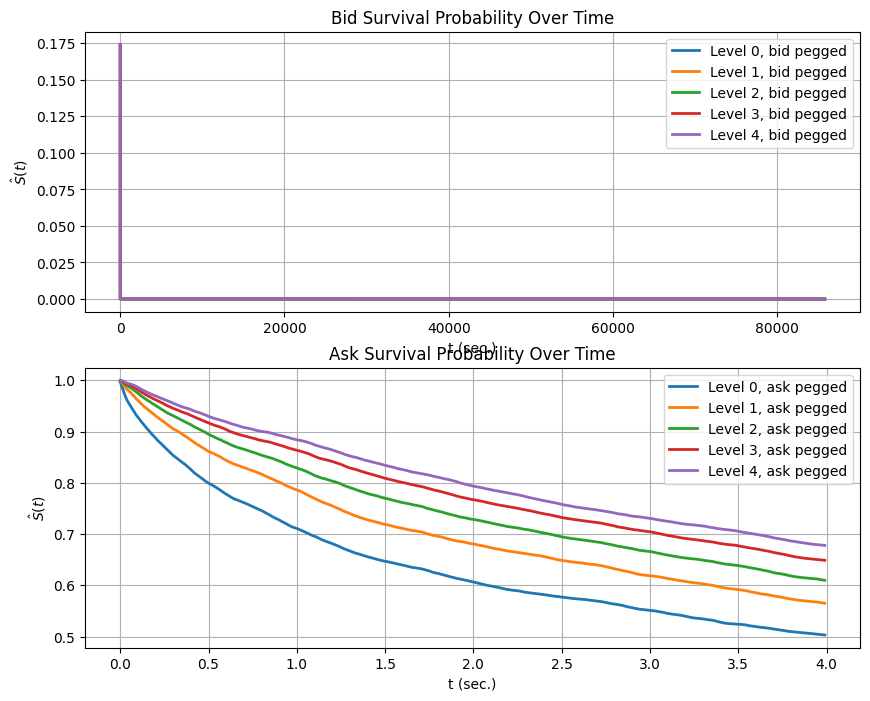

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for column in columns:
  KM_est, times = plot_KM_estimator(column)
  if 'bid' in column:
    ax1.plot(times[:len(times)//10], KM_est[:len(times)//10], linewidth=2, label=f"Level {column.split('_')[-1]}, {column.split('_')[0]} pegged")
    ax1.set_xlabel('t (sec.)')
    ax1.set_ylabel('$\hat{S}(t)$')
    ax1.set_title('Bid Survival Probability Over Time')
    ax1.legend()
    ax1.grid(True)

  else:
    ax2.plot(times[:len(times)//10], KM_est[:len(times)//10], linewidth=2, label=f"Level {column.split('_')[-1]}, {column.split('_')[0]} pegged")
    ax2.set_xlabel('t (sec.)')
    ax2.set_ylabel('$\hat{S}(t)$')
    ax2.set_title('Ask Survival Probability Over Time')
    ax2.legend()
    ax2.grid(True)

plt.show()

In [12]:
#Make some features and drop useless columns
pd.options.mode.chained_assignment = None

df['vol_imbalance'] = (df['bid_quantity_0'] - df['ask_quantity_0'])/(df['bid_quantity_0'] + df['ask_quantity_0'])
df['microprice'] = ((df['bid_prices_0']*df['bid_quantity_0']+df['ask_prices_0']*df['ask_quantity_0'])
                    /(df['bid_quantity_0'] + df['ask_quantity_0']))

def logReturns(S):
    return np.log(S/S.shift(1))

def volFromTimeSeriesPerSecond(prices, timeStamps):
    if np.size(prices) <= 2:
        raise ValueError('We need more prices than 2')

    # Convert timestamp strings to datetime
    timeStamps = pd.to_datetime(timeStamps)

    x = logReturns(prices)[1:]  # the value at the first index is NaN
    xBar = np.mean(x)

    # Calculate deltaT in seconds
    deltaT = (timeStamps - timeStamps.shift(10)).dt.total_seconds()[1:]  # the value at the first index is NaN
    N = np.size(x)

    return np.sqrt(np.sum((x - xBar) ** 2 / deltaT) / (N - 1))

def volFromTimeSeriesPerHour(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0)

def volFromTimeSeriesPerDay(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24)

def volFromTimeSeriesPerYear(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24*365.25)


print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(df['microprice'], df['timestamp'])))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(df['microprice'], df['timestamp'])))

Vol is 0.14% per second
Vol is 8.53% per hour
Vol is 41.79% per day
Vol is 798.71% per year


In [13]:
def calculate_volatility(prices, timeStamps):
    if len(prices) <= 1:
        return np.nan  # Not enough data

    x = logReturns(prices)
    xBar = np.mean(x)
    i=10
    deltaT = (timeStamps - timeStamps.shift(i)).dt.total_seconds()
    N = len(x)

    return np.sqrt(np.nansum((x - xBar) ** 2 / deltaT) / (N - 1))

# Define a function to calculate rolling volatility
def rolling_volatility(df, window_size):
    # Convert timestamp strings to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Apply the rolling window
    rolling_vol = df['microprice'].rolling(window=window_size).apply(
        lambda x: calculate_volatility(x, df['timestamp']), raw=False
    )

    return rolling_vol

window_size = 1000

# Calculate rolling volatility and add it as a new column
df['daily_volatility'] = rolling_volatility(df, window_size)

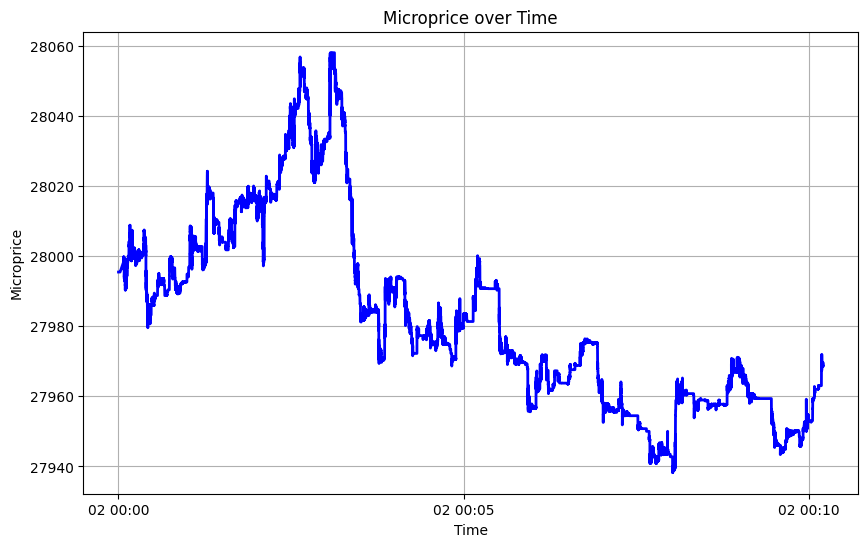

In [14]:
plt.figure(figsize=(10, 6))

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['microprice'], color='blue', linewidth=2, label='Microprice')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Microprice')
plt.title('Microprice over Time')

# Displaying the grid
plt.grid(True)

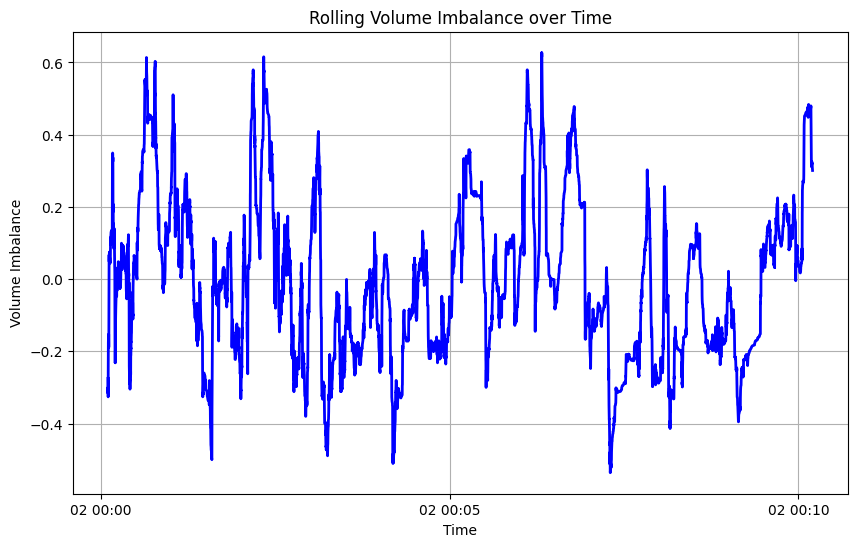

In [19]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['vol_imbalance'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Rolling Volume Imbalance')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Volume Imbalance')
plt.title('Rolling Volume Imbalance over Time')

# Displaying the grid
plt.grid(True)

In [15]:
df['daily_volatility'] = df['daily_volatility']*np.sqrt(360000.0*24)*100
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,time_ask_prices_1,time_bid_prices_2,time_ask_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4,vol_imbalance,microprice,daily_volatility
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,4.29,0.15,4.29,0.15,4.29,0.15,4.29,0.890551,27995.450547,NaN
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,4.14,0.04,4.14,0.04,4.14,0.04,4.14,0.890551,27995.450547,NaN
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,4.09,0.06,4.09,0.06,4.09,0.06,4.09,0.751171,27995.451244,NaN
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,4.03,0.09,4.03,0.09,4.03,0.09,4.03,0.751171,27995.451244,NaN
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,3.94,0.00,3.94,0.00,3.94,0.00,3.94,0.751894,27995.451241,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020000,27968.26,27970.25,0.020000,0.053564,27967.98,...,85787.85,0.00,85787.85,0.00,85787.85,0.00,85787.85,0.791124,27968.475743,74.788650
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,85787.85,0.00,85787.85,0.00,85787.85,0.00,85787.85,0.775408,27968.500100,74.790967
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,85787.84,0.00,85787.84,0.00,85787.84,0.00,85787.84,0.775408,27968.500100,74.790958
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,85787.84,0.00,85787.84,0.00,85787.84,0.00,85787.84,0.775408,27968.500100,74.790948


In [16]:
threshold=10
for column in columns:
  df['time_' + column] = df['time_' + column].apply(lambda x: 1 if x < threshold else 0)

In [17]:
df.dropna(inplace=True)
df.describe()

,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,ask_prices_2,...,time_ask_prices_1,time_bid_prices_2,time_ask_prices_2,time_bid_prices_3,time_ask_prices_3,time_bid_prices_4,time_ask_prices_4,vol_imbalance,microprice,daily_volatility
count,102087.000000,102087.000000,1.020870e+05,1.020870e+05,102087.000000,102087.000000,1.020870e+05,102087.000000,102087.000000,102087.000000,...,102087.000000,102087.00000,102087.000000,102087.00000,102087.000000,102087.00000,102087.000000,102087.000000,102087.000000,102087.000000
mean,27990.290168,27991.935258,1.731104e-01,1.679133e-01,27989.765561,27992.535251,1.937127e-01,0.155106,27989.369334,27993.047075,...,0.619344,0.99999,0.584110,0.99999,0.553303,0.99999,0.525650,0.007154,27991.118443,213.727257
std,28.823251,28.959333,2.866734e-01,4.303660e-01,28.754530,28.991063,3.350312e-01,0.514485,28.701522,29.012590,...,0.485550,0.00313,0.492877,0.00313,0.497153,0.00313,0.499344,0.636706,28.890998,359.445916
min,27938.200000,27938.980000,3.000000e-08,1.000000e-08,27936.380000,27938.990000,3.500000e-07,0.000002,27936.270000,27939.270000,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,-1.000000,27938.219139,8.214423
25%,27965.640000,27967.610000,4.000000e-02,4.000000e-02,27965.180000,27968.430000,4.649566e-02,0.045106,27964.730000,27969.140000,...,0.000000,1.00000,0.000000,1.00000,0.000000,1.00000,0.000000,-0.569507,27966.562814,32.991369
50%,27990.360000,27991.140000,8.000000e-02,7.271321e-02,27989.610000,27991.950000,8.927587e-02,0.072713,27989.120000,27992.340000,...,1.000000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,0.008964,27990.763831,59.460616
75%,28013.170000,28014.820000,2.500000e-01,2.405333e-01,28012.420000,28015.030000,2.500000e-01,0.212412,28012.150000,28015.100000,...,1.000000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,0.580512,28013.893711,188.473722
max,28057.990000,28058.000000,5.000000e+00,1.874256e+01,28057.550000,28062.620000,5.000000e+00,18.742559,28057.540000,28062.900000,...,1.000000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,28058.000000,2006.112857


In [18]:
df.to_csv('prepared_LOB_trunc_data.csv')

In [19]:
N = 500  # Define the number of previous observations included

# Assuming 'columns' is a list of column names and 'column' is a specific column name
columns_to_drop = ['time_' + col for col in columns] + ['timestamp']
X = df.drop(columns=columns_to_drop).iloc[:len(df)]
Y = df[['time_' + col for col in columns]].iloc[N:len(df)].values

print(Y.shape)

(101587, 10)


In [20]:
tensor_slices = []

for i in range(N, len(X)):
    start_index = max(0, i - N)
    slice_df = X.iloc[start_index:i+1]

    tensor_slice = tf.convert_to_tensor(slice_df, dtype=tf.float32)
    tensor_slices.append(tensor_slice)

X = tf.stack(tensor_slices)

X.shape

TensorShape([101587, 501, 23])

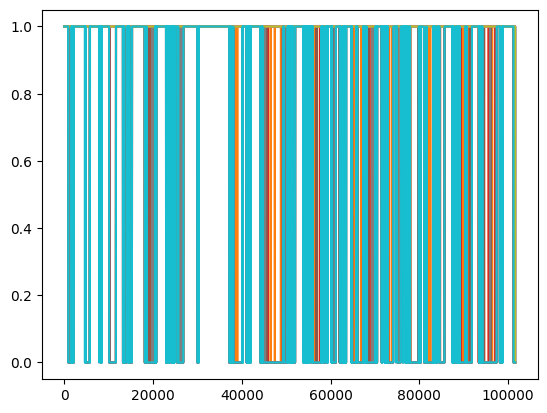

In [21]:
plt.plot(Y)

In [41]:
print('X shape :', X.shape)
print('Y shape :',Y.shape[0])

X shape : (101587, 501, 23)
Y shape : 101587


In [43]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size_Q, kernel_size_K, kernel_size_V, units, dilation_rate, num_heads):
        super(Encoder, self).__init__()
        self.units = units
        self.dilation_rate = dilation_rate

        # Dilated Convolution layer
        self.dilated_conv_Q = tf.keras.layers.Conv1D(kernel_size=kernel_size_Q,
                                                  filters=filters,
                                                  dilation_rate=self.dilation_rate,
                                                  padding='causal',
                                                  activation='relu')

        self.dilated_conv_K = tf.keras.layers.Conv1D(kernel_size=kernel_size_K,
                                                  filters=filters,
                                                  dilation_rate=self.dilation_rate,
                                                  padding='causal',
                                                  activation='relu')

        self.dilated_conv_V = tf.keras.layers.Conv1D(kernel_size=kernel_size_V,
                                                  filters=filters,
                                                  dilation_rate=self.dilation_rate,
                                                  padding='causal',
                                                  activation='relu')


        # Multi-Head Attention layer with 3 heads
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=16)

        # Flatten layer to reduce to a one-dimensional array
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x):
        print('init', x)
        # Dilated Convolution
        Q = self.dilated_conv_Q(x)
        K = self.dilated_conv_K(x)
        V = self.dilated_conv_V(x)
        # Multi-Head Attention
        x = self.multi_head_attention(Q, K, V)

        # Flatten the output
        x = self.flatten(x)
        print('final', x)

        return x

class SimpleDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers=10, units_per_layer=64, activation='relu',
                 l1_reg=0.1, dropout_rate=0.1, initializer='glorot_uniform'):
        super(SimpleDecoder, self).__init__()
        self.num_layers = num_layers
        self.units_per_layer = units_per_layer
        self.activation = activation
        self.l1_reg = l1_reg
        self.dropout_rate = dropout_rate

        # Initialize dense layers with L1 regularization, Dropout layers, and custom initializer
        self.layers = []
        for _ in range(num_layers):
            self.layers.append(layers.Dense(units=self.units_per_layer,
                                            activation=self.activation,
                                            kernel_regularizer=regularizers.l1(self.l1_reg),
                                            kernel_initializer=initializer))
            self.layers.append(layers.Dropout(self.dropout_rate))

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)  # Only apply dropout during training
            else:
                x = layer(x)
        return x

def create_encoder(input_shape, d_model, num_heads, dilation_rate, kernel_size_Q,
                   kernel_size_K, kernel_size_V):
    return Encoder(units=d_model, filters=filters, kernel_size_Q=kernel_size_Q,
                   kernel_size_K=kernel_size_K, kernel_size_V=kernel_size_V, dilation_rate=dilation_rate, num_heads=num_heads)

# Combine the encoder and decoder to create the full model
def create_full_model(input_shape, filters, num_heads, d_model, output_shape, units,
                      kernel_size_Q, kernel_size_K, kernel_size_V):
    encoder_inputs = layers.Input(shape=input_shape)
    encoder = create_encoder(input_shape, d_model, num_heads, filters, kernel_size_Q,
                             kernel_size_K, kernel_size_V)
    encoder_output = encoder(encoder_inputs)

    decoder = SimpleDecoder()
    decoder_output = decoder(encoder_output)

    # Flatten the decoder output if not already flattened
    flat_output = tf.keras.layers.Flatten()(decoder_output)
    output = tf.keras.layers.Dense(output_shape, activation= 'sigmoid')(flat_output)
    full_model = tf.keras.models.Model(inputs=encoder_inputs, outputs=output)

    return full_model

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
filters = 2
units = 4
kernel_size_Q, kernel_size_K, kernel_size_V = 2, 3, 4
num_heads = 3
d_model = 2
output_shape = Y.shape[1]
batch = 16

# Create the model
model = create_full_model(input_shape, filters, num_heads, d_model, output_shape, units, kernel_size_Q, kernel_size_K, kernel_size_V)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=10**(-4)),
              loss='binary_crossentropy')

# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.fit(x=X, y=Y, batch_size=batch, epochs=100, callbacks=[callback])

init Tensor("Placeholder:0", shape=(None, 501, 23), dtype=float32)
final Tensor("encoder_8/flatten_13/Reshape:0", shape=(None, 1002), dtype=float32)
Epoch 1/100
init Tensor("IteratorGetNext:0", shape=(None, 501, 23), dtype=float32)
final Tensor("model_5/encoder_8/flatten_13/Reshape:0", shape=(None, 1002), dtype=float32)
init Tensor("IteratorGetNext:0", shape=(None, 501, 23), dtype=float32)
final Tensor("model_5/encoder_8/flatten_13/Reshape:0", shape=(None, 1002), dtype=float32)
6350/6350 [==============================] - 74s 11ms/step - loss: 104.4746
Epoch 2/100
6350/6350 [==============================] - 71s 11ms/step - loss: 0.4493
Epoch 3/100
6350/6350 [==============================] - 70s 11ms/step - loss: 0.4436
Epoch 4/100
6350/6350 [==============================] - 71s 11ms/step - loss: 0.4431
Epoch 5/100
6350/6350 [==============================] - 71s 11ms/step - loss: 0.4429
Epoch 6/100
6350/6350 [==============================] - 70s 11ms/step - loss: 0.4427
Epoch 7/100

In [ ]:
Y_pred = model.predict(X)

plt.plot(Y_pred)

# Training Visualization

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10**(-4))
loss_fn = tf.keras.losses.BinaryCrossentropy()

@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, gradients

def plot_distribution(data, title):
    plt.hist(data.flatten(), bins=50)
    plt.title(title)
    plt.show()

# Assuming X and Y are your data and labels
for epoch in range(10):
    for step in range(0, len(X), batch):
        x_batch = X[step:step + batch]
        y_batch = Y[step:step + batch]

        loss, gradients = train_step(model, x_batch, y_batch)

        # Every N steps, visualize weights, activations, and gradients
        if step % 100 == 0:
            # Visualize weights and gradients
            for var, grad in zip(model.trainable_variables, gradients):
                plot_distribution(var.numpy(), f'Weights of {var.name}')
                plot_distribution(grad.numpy(), f'Gradients of {var.name}')

            # Visualize activations
            intermediate_model = tf.keras.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])
            activations = intermediate_model.predict(x_batch)
            for i, activation in enumerate(activations):
                plot_distribution(activation, f'Activation of layer {i+1}')

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = Y.shape[1]

In [ ]:
# Optuna objective function
def objective(trial):
    # Suggest values for the hyperparameters
    num_heads = trial.suggest_categorical('num_heads', [2, 4, 8, 16])
    filters = trial.suggest_categorical('filters', [2, 4, 8, 16])
    units = trial.suggest_categorical('units', [1, 4, 8, 16, 32])
    kernel_size_Q = trial.suggest_categorical('kernel_size_Q', [2, 4, 8, 16])
    kernel_size_K = trial.suggest_categorical('kernel_size_K', [2, 4, 8, 16])
    kernel_size_V = trial.suggest_categorical('kernel_size_V', [2, 4, 8, 16])
    dilation_rate = trial.suggest_categorical('dilation_rate', [1, 2, 3, 4])
    d_model = trial.suggest_categorical('d_model', [1, 2, 4, 8, 32])
    batch = trial.suggest_categorical('batch', [4, 8, 16, 32])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-6, 1e-5, 1e-4, 1e-3, 1e-1])  # Suggest learning rate

    # Create the model using the suggested values
    model = create_full_model(input_shape, filters, num_heads, d_model, output_shape, units,
                              kernel_size_Q, kernel_size_K, kernel_size_V)

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),loss='binary_crossentropy')

    train_ds = tf.data.Dataset.from_tensor_slices((X, Y)).batch(batch_size = batch)

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    history = model.fit(train_ds, epochs=50, callbacks=[callback], verbose=1)

    val_loss = sum(history.history['loss'][-6:-1])/5
    return val_loss

# Optuna study
study = optuna.create_study(direction='minimize')  # 'minimize' if lower loss is better, 'maximize' otherwise
study.optimize(objective, n_trials=50)  # Adjust the number of trials

# Print the optimal hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# Define model parameters
input_shape = (N+1, 23)
output_shape = Y.shape[1]
num_heads = trial.params['num_heads']
filters = trial.params['filters']
units = trial.params['units']
kernel_size_Q = trial.params['kernel_size_Q']
kernel_size_K = trial.params['kernel_size_K']
kernel_size_V = trial.params['kernel_size_V']
batch = trial.params['batch']
learning_rate = trial.params['learning_rate']
# Create the model
model = create_full_model(input_shape, filters, num_heads, d_model, output_shape, units,
                              kernel_size_Q, kernel_size_K, kernel_size_V)
# Create TensorFlow dataset
train_ds = tf.data.Dataset.from_tensor_slices((X, Y)).batch(batch_size=batch)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss='mse')

# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
model.fit(train_ds, epochs=100, callbacks=[callback])

In [ ]:
Y_pred = model.predict(X)

In [ ]:
plt.plot(Y_pred)
plt.plot(Y)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [ ]:
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X,
    feature_names=X.columns,
    output_names=["Prediction"]
)

# Generate the waterfall plot for the first prediction
shap.waterfall_plot(shap_explanation[0])